<a href="https://www.kaggle.com/code/ravaghi/s05e04-podcast-listening-time-ridge?scriptVersionId=234411313" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install ydf scikit-learn==1.5.2 && pip install --no-deps scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 82.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


# Imports and configs

In [2]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, TargetEncoder
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.base import clone
from scikeras.wrappers import KerasRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from ydf import GradientBoostedTreesLearner
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import contextlib, io
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import shutil
import optuna
import keras
import json
import glob
import ydf
import os
import gc

ydf.verbose(2)
warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e4/train.csv"
    test_path = "/kaggle/input/playground-series-s5e4/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e4/sample_submission.csv"

    original_path = "/kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset.csv"
    
    target = "Listening_Time_minutes"
    metric = "RMSE"
    n_folds = 5
    seed = 42

    run_optuna = True
    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

original = pd.read_csv(CFG.original_path)
original = original.dropna(subset=[CFG.target])
original = original.drop_duplicates()

cat_cols = test.select_dtypes(include="object").columns.tolist()
train[cat_cols] = train[cat_cols].astype(str).astype("category")
test[cat_cols] = test[cat_cols].astype(str).astype("category")
original[cat_cols] = original[cat_cols].astype(str).astype("category")

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

X_original = original.drop(CFG.target, axis=1)
y_original = original[CFG.target]

# Training base models

In [5]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config
        
    def train(self, X, y, X_test, X_original=None, y_original=None):       
        print(f"Training {self.model.__class__.__name__}\n")
                
        scores = []
        oof_preds = np.zeros(X.shape[0])
        test_preds = np.zeros(X_test.shape[0])
        coeffs = np.zeros((1, X.shape[1]))
        
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            if X_original is not None and y_original is not None:
                X_train = pd.concat([X_train, X_original])
                y_train = pd.concat([y_train, y_original])
            
            y_preds, temp_test_preds, score, _coeff = self._fit_predict(fold_idx, X_train, y_train, X_val, y_val, X_test)
            oof_preds[val_idx] = y_preds
            test_preds += temp_test_preds / self.config.n_folds
            scores.append(score)
            if _coeff is not None:
                coeffs += _coeff / self.config.n_folds
            
            del X_train, y_train, X_val, y_val, y_preds, temp_test_preds
            gc.collect() 
            
        overall_score = root_mean_squared_error(y, oof_preds)
        average_score = np.mean(scores)
        
        self._save_results(oof_preds, test_preds, overall_score)
        print(f"\n------ Overall {CFG.metric}: {overall_score:.6f} - Average {CFG.metric}: {average_score:.6f}")
        
        return oof_preds, test_preds, scores, coeffs
    
    def tune(self, X, y):                       
        oof_preds = np.zeros(X.shape[0])
        
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
                
            model = clone(self.model)
            model.fit(X_train, y_train)

            oof_preds[val_idx] = model.predict(X_val)
                
            del X_train, y_train, X_val, y_val
            gc.collect() 
            
        return root_mean_squared_error(y, oof_preds)
        
    def _save_results(self, oof_preds, test_preds, cv_score):            
        if isinstance(self.model, (Ridge, Lasso)):
            pass
        else:
            model_name = self.model.__class__.__name__.lower().replace("regressor", "")
            if model_name == "lgbm":
                model_name = "lgbm-" + self.model.boosting_type
            
            if model_name == "bagging":
                model_name = "keras-ann"
            
            os.makedirs(f"oof/{model_name}", exist_ok=True)
            
            joblib.dump(oof_preds, f"oof/{model_name}/{model_name}_oof_preds_{cv_score:.6f}.pkl")
            joblib.dump(test_preds, f"oof/{model_name}/{model_name}_test_preds_{cv_score:.6f}.pkl")
            
    def _fit_predict(self, fold_idx, X_train, y_train, X_val, y_val, X_test):
        if isinstance(self.model, LGBMRegressor):
            y_preds, test_preds = self._fit_lightgbm(X_train, y_train, X_val, y_val, X_test)
        elif isinstance(self.model, XGBRegressor):
            y_preds, test_preds = self._fit_xgboost(X_train, y_train, X_val, y_val, X_test)
        elif isinstance(self.model, CatBoostRegressor):
            y_preds, test_preds = self._fit_catboost(X_train, y_train, X_val, y_val, X_test)
        else:
            model = clone(self.model)
            model.fit(X_train, y_train)
            y_preds = model.predict(X_val)
            test_preds = model.predict(X_test)
            
        score = root_mean_squared_error(y_val, np.maximum(y_preds, 0))
        
        if isinstance(self.model, (CatBoostRegressor, LGBMRegressor, XGBRegressor)):
            print(f"\n--- Fold {fold_idx + 1} - {CFG.metric}: {score:.6f}\n\n")
        else:
            print(f"--- Fold {fold_idx + 1} - {CFG.metric}: {score:.6f}")
            
        coeff = model.coef_ if isinstance(self.model, (Ridge, Lasso)) else None
        return y_preds, test_preds, score, coeff
        
    def _fit_lightgbm(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)
        model.fit(
            X_train, 
            y_train, 
            eval_metric="rmse",
            eval_set=[(X_val, y_val)], 
            callbacks=[
                log_evaluation(period=200), 
                early_stopping(stopping_rounds=100)
            ]
        )
        
        y_preds = model.predict(X_val)
        test_preds = model.predict(X_test)
        del model
        
        return y_preds, test_preds
    
    def _fit_xgboost(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)
        model.fit(
                X_train, 
                y_train, 
                eval_set=[(X_val, y_val)], 
                verbose=200
            )
        
        y_preds = model.predict(X_val)
        test_preds = model.predict(X_test)
        del model
        
        return y_preds, test_preds
    
    def _fit_catboost(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)

        cat_cols = X_train.select_dtypes(include="category").columns.tolist()
        if len(cat_cols) > 0:
            train_pool = Pool(X_train, y_train, cat_features=cat_cols)
            val_pool = Pool(X_val, y_val, cat_features=cat_cols)
            test_pool = Pool(X_test, cat_features=cat_cols)
        else:
            train_pool = Pool(X_train, y_train)
            val_pool = Pool(X_val, y_val)
            test_pool = Pool(X_test)

        model.fit(
            X=train_pool, 
            eval_set=val_pool, 
            verbose=200, 
            early_stopping_rounds=100,
            use_best_model=True
        )
        
        y_preds = model.predict(val_pool)
        test_preds = model.predict(test_pool)
        del model
        
        return y_preds, test_preds

In [6]:
histgb_params = {
    "categorical_features": "from_dtype",
    "l2_regularization": 83.89023753261954,
    "learning_rate": 0.014076263018504506,
    "max_depth": 167,
    "max_features": 0.35671906170746404,
    "max_iter": 2175,
    "max_leaf_nodes": 441,
    "min_samples_leaf": 41,
    "random_state": 42
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.5099047573235393,
    "learning_rate": 0.04655222942419148,
    "min_child_samples": 39,
    "min_child_weight": 0.5763597850247795,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 94,
    "random_state": 42,
    "reg_alpha": 13.37124947203867,
    "reg_lambda": 3.4607082189282656,
    "subsample": 0.8594971769419172,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.44242724444333914,
    "learning_rate": 0.02648790357768195,
    "min_child_samples": 31,
    "min_child_weight": 0.565923097348698,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 91,
    "random_state": 42,
    "reg_alpha": 14.802741846604295,
    "reg_lambda": 3.285199583781151,
    "subsample": 0.4765616561570595,
    "verbose": -1
}

xgb_params = {
    "colsample_bylevel": 0.562776356802306,
    "colsample_bynode": 0.9612908685331664,
    "colsample_bytree": 0.6576899092549643,
    "early_stopping_rounds": 100,
    "enable_categorical": True,
    "eval_metric": "rmse",
    "gamma": 6.906307575453604,
    "learning_rate": 0.035818175355750034,
    "max_depth": 79,
    "max_leaves": 94,
    "min_child_weight": 54,
    "n_estimators": 10000,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 40.48896149819585,
    "reg_lambda": 50.48291846164928,
    "subsample": 0.987369044259711,
    "verbosity": 0
}

cb_params = {
    "border_count": 197,
    "colsample_bylevel": 0.5512194940746528,
    "depth": 10,
    "eval_metric": "RMSE",
    "iterations": 5000,
    "l2_leaf_reg": 0.8315140039900148,
    "learning_rate": 0.04835894985543038,
    "min_child_samples": 248,
    "random_state": 42,
    "random_strength": 0.269215705791639,
    "verbose": False
}

ydf_params = {
    "num_trees": 1000,
    "max_depth": 8
}

In [7]:
scores = {}
oof_preds = {}
test_preds = {}

## HistGradientBoosting

In [8]:
histgb_model = HistGradientBoostingRegressor(**histgb_params)
histgb_trainer = Trainer(histgb_model)
oof_preds["HistGB"], test_preds["HistGB"], scores["HistGB"], _ = histgb_trainer.train(X, y, X_test, X_original, y_original)

Training HistGradientBoostingRegressor

--- Fold 1 - RMSE: 12.794589
--- Fold 2 - RMSE: 12.834127
--- Fold 3 - RMSE: 12.853394
--- Fold 4 - RMSE: 12.834924
--- Fold 5 - RMSE: 12.792689

------ Overall RMSE: 12.821996 - Average RMSE: 12.821945


## LightGBM (gbdt)

In [9]:
lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
oof_preds["LightGBM"], test_preds["LightGBM"], scores["LightGBM"], _ = lgbm_trainer.train(X, y, X_test, X_original, y_original)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 12.9778	valid_0's l2: 168.423
[400]	valid_0's rmse: 12.921	valid_0's l2: 166.953
[600]	valid_0's rmse: 12.8953	valid_0's l2: 166.289
[800]	valid_0's rmse: 12.8748	valid_0's l2: 165.76
[1000]	valid_0's rmse: 12.8592	valid_0's l2: 165.36
[1200]	valid_0's rmse: 12.8451	valid_0's l2: 164.996
[1400]	valid_0's rmse: 12.834	valid_0's l2: 164.712
[1600]	valid_0's rmse: 12.8245	valid_0's l2: 164.467
[1800]	valid_0's rmse: 12.8158	valid_0's l2: 164.246
[2000]	valid_0's rmse: 12.8103	valid_0's l2: 164.103
[2200]	valid_0's rmse: 12.8036	valid_0's l2: 163.933
[2400]	valid_0's rmse: 12.7978	valid_0's l2: 163.784
[2600]	valid_0's rmse: 12.7916	valid_0's l2: 163.624
[2800]	valid_0's rmse: 12.7869	valid_0's l2: 163.505
[3000]	valid_0's rmse: 12.7822	valid_0's l2: 163.384
[3200]	valid_0's rmse: 12.778	valid_0's l2: 163.277
[3400]	valid_0's rmse: 12.774	valid_0's l2: 163.176
[3600]	valid_0's rmse: 

## LightGBM (goss)

In [10]:
lgbm_goss_model = LGBMRegressor(**lgbm_goss_params)
lgbm_goss_trainer = Trainer(lgbm_goss_model)
oof_preds["LightGBM (goss)"], test_preds["LightGBM (goss)"], scores["LightGBM (goss)"], _ = lgbm_goss_trainer.train(X, y, X_test, X_original, y_original)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 13.0347	valid_0's l2: 169.904
[400]	valid_0's rmse: 12.9681	valid_0's l2: 168.173
[600]	valid_0's rmse: 12.9435	valid_0's l2: 167.535
[800]	valid_0's rmse: 12.9261	valid_0's l2: 167.085
[1000]	valid_0's rmse: 12.9106	valid_0's l2: 166.683
[1200]	valid_0's rmse: 12.8978	valid_0's l2: 166.354
[1400]	valid_0's rmse: 12.8877	valid_0's l2: 166.093
[1600]	valid_0's rmse: 12.8795	valid_0's l2: 165.881
[1800]	valid_0's rmse: 12.8702	valid_0's l2: 165.643
[2000]	valid_0's rmse: 12.8631	valid_0's l2: 165.459
[2200]	valid_0's rmse: 12.8579	valid_0's l2: 165.326
[2400]	valid_0's rmse: 12.8532	valid_0's l2: 165.204
[2600]	valid_0's rmse: 12.8481	valid_0's l2: 165.075
[2800]	valid_0's rmse: 12.8438	valid_0's l2: 164.964
[3000]	valid_0's rmse: 12.8401	valid_0's l2: 164.868
[3200]	valid_0's rmse: 12.8374	valid_0's l2: 164.8
[3400]	valid_0's rmse: 12.8346	valid_0's l2: 164.727
[3600]	valid_0's rm

## XGBoost

In [11]:
xgb_model = XGBRegressor(**xgb_params)
xgb_trainer = Trainer(xgb_model)
oof_preds["XGBoost"], test_preds["XGBoost"], scores["XGBoost"], _ = xgb_trainer.train(X, y, X_test, X_original, y_original)

Training XGBRegressor

[0]	validation_0-rmse:26.44402
[200]	validation_0-rmse:13.08083
[400]	validation_0-rmse:13.00471
[600]	validation_0-rmse:12.97737
[800]	validation_0-rmse:12.95661
[1000]	validation_0-rmse:12.94248
[1200]	validation_0-rmse:12.93056
[1400]	validation_0-rmse:12.92055
[1600]	validation_0-rmse:12.91105
[1800]	validation_0-rmse:12.90305
[2000]	validation_0-rmse:12.89701
[2200]	validation_0-rmse:12.89103
[2400]	validation_0-rmse:12.88670
[2600]	validation_0-rmse:12.88269
[2800]	validation_0-rmse:12.87837
[3000]	validation_0-rmse:12.87388
[3200]	validation_0-rmse:12.87109
[3400]	validation_0-rmse:12.86827
[3600]	validation_0-rmse:12.86465
[3800]	validation_0-rmse:12.86245
[4000]	validation_0-rmse:12.85940
[4200]	validation_0-rmse:12.85723
[4400]	validation_0-rmse:12.85569
[4600]	validation_0-rmse:12.85453
[4800]	validation_0-rmse:12.85266
[5000]	validation_0-rmse:12.85226
[5075]	validation_0-rmse:12.85208

--- Fold 1 - RMSE: 12.851567


[0]	validation_0-rmse:26.47696
[20

## CatBoost

In [12]:
cb_model = CatBoostRegressor(**cb_params)
cb_trainer = Trainer(cb_model)
oof_preds["CatBoost"], test_preds["CatBoost"], scores["CatBoost"], _ = cb_trainer.train(X, y, X_test, X_original, y_original)

Training CatBoostRegressor

0:	learn: 26.1835620	test: 26.1668139	best: 26.1668139 (0)	total: 717ms	remaining: 59m 43s
200:	learn: 13.0820075	test: 13.0684685	best: 13.0684685 (200)	total: 1m 47s	remaining: 42m 56s
400:	learn: 12.9372814	test: 13.0249281	best: 13.0249281 (400)	total: 3m 43s	remaining: 42m 41s
600:	learn: 12.8110930	test: 13.0005064	best: 13.0005064 (600)	total: 5m 40s	remaining: 41m 30s
800:	learn: 12.6874239	test: 12.9797094	best: 12.9796961 (799)	total: 7m 38s	remaining: 40m 5s
1000:	learn: 12.5828187	test: 12.9650688	best: 12.9650688 (1000)	total: 9m 40s	remaining: 38m 38s
1200:	learn: 12.4765928	test: 12.9549155	best: 12.9549155 (1200)	total: 11m 40s	remaining: 36m 55s
1400:	learn: 12.3687038	test: 12.9451445	best: 12.9451445 (1400)	total: 13m 41s	remaining: 35m 10s
1600:	learn: 12.2643715	test: 12.9373595	best: 12.9373482 (1596)	total: 15m 42s	remaining: 33m 20s
1800:	learn: 12.1678262	test: 12.9312235	best: 12.9312056 (1799)	total: 17m 45s	remaining: 31m 32s
2000

## Yggdrasil

In [13]:
def YDFRegressor(learner_class):

    class YDFXRegressor(BaseEstimator, RegressorMixin):

        def __init__(self, params={}):
            self.params = params

        def fit(self, X, y):
            assert isinstance(X, pd.DataFrame)
            assert isinstance(y, pd.Series)
            target = y.name
            params = self.params.copy()
            params['label'] = target
            params['task'] = ydf.Task.REGRESSION
            X = pd.concat([X, y], axis=1)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                self.model = learner_class(**params).train(X)
            return self

        def predict(self, X):
            assert isinstance(X, pd.DataFrame)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                return self.model.predict(X)

    return YDFXRegressor

In [14]:
ydf_model = YDFRegressor(GradientBoostedTreesLearner)(ydf_params)
ydf_trainer = Trainer(ydf_model)
oof_preds["Yggdrasil"], test_preds["Yggdrasil"], scores["Yggdrasil"], _ = ydf_trainer.train(X, y, X_test, X_original, y_original)

Training YDFXRegressor

--- Fold 1 - RMSE: 12.940558
--- Fold 2 - RMSE: 12.988787
--- Fold 3 - RMSE: 12.986136
--- Fold 4 - RMSE: 12.987160
--- Fold 5 - RMSE: 12.939877

------ Overall RMSE: 12.968561 - Average RMSE: 12.968504


## AutoGluon

In [15]:
oof_preds_files = glob.glob(f'/kaggle/input/s05e04-podcast-listening-time-autogluon/*_oof_preds_*.pkl')
test_preds_files = glob.glob(f'/kaggle/input/s05e04-podcast-listening-time-autogluon/*_test_preds_*.pkl')

ag_oof_preds = joblib.load(oof_preds_files[0])
ag_test_preds = joblib.load(test_preds_files[0])

ag_scores = []
split = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(X, y)
for _, val_idx in split:
    y_val = y[val_idx]
    y_preds = ag_oof_preds[val_idx]   
    score = root_mean_squared_error(y_preds, y_val)
    ag_scores.append(score)
    
oof_preds["AutoGluon"], test_preds["AutoGluon"], scores["AutoGluon"] = ag_oof_preds, ag_test_preds, ag_scores

## Neural network

In [16]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

original = pd.read_csv(CFG.original_path)
original = original.dropna(subset=[CFG.target])
original = original.drop_duplicates()

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

X_original = original.drop(CFG.target, axis=1)
y_original = original[CFG.target]

In [17]:
X_test.loc[X_test["Episode_Length_minutes"] > 500, "Episode_Length_minutes"] = None

In [18]:
cat_cols = ['Podcast_Name', 'Episode_Title']
ohe_cols = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
num_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']

pipeline = make_pipeline(
    ColumnTransformer(
        [
            ('one-hot-encode', OneHotEncoder(drop='first', sparse_output=False, dtype=np.float32, handle_unknown='ignore'), ohe_cols),
            ('target-encode', make_pipeline(TargetEncoder(), FunctionTransformer(lambda x: x.astype(np.float32)), StandardScaler()), cat_cols),
            ('impute-nums', make_pipeline(SimpleImputer(strategy='mean'), FunctionTransformer(lambda x: x.astype(np.float32)), StandardScaler()), num_cols),
        ]
    )
).set_output(transform='pandas')

X = pipeline.fit_transform(X, y)
X_test = pipeline.transform(X_test)
X_original = pipeline.transform(X_original)

In [19]:
def get_model(meta):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(meta["X_shape_"][1:]))
    model.add(keras.layers.Dense(256, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(128, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(1))
    return model

In [20]:
def scheduler(epoch, lr):    
    if epoch % 3 == 0 and epoch:
        return lr / 2
    return lr

nn_model = KerasRegressor(
    get_model,
    loss="mean_squared_error",
    random_state=CFG.seed,
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')],
    optimizer=keras.optimizers.AdamW(learning_rate=0.01),
    validation_batch_size=65536,
    validation_split=0.1,
    batch_size=1024,
    epochs=50, 
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_rmse', patience=7, restore_best_weights=True),
        keras.callbacks.LearningRateScheduler(scheduler)
    ]
)

In [21]:
nn_trainer = Trainer(BaggingRegressor(
    nn_model,
    n_estimators=3,
    random_state=CFG.seed,
))
    
_, _, scores["KerasANN"], _ = nn_trainer.train(X, y, X_test, X_original, y_original)

Training BaggingRegressor

--- Fold 1 - RMSE: 13.166310
--- Fold 2 - RMSE: 13.218980
--- Fold 3 - RMSE: 13.223325
--- Fold 4 - RMSE: 13.222355
--- Fold 5 - RMSE: 13.192047

------ Overall RMSE: 13.204622 - Average RMSE: 13.204603


# Ensembling with Ridge

In [22]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [23]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [24]:
def objective(trial):    
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 10),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2)
    }
    
    model = Ridge(**params)
    trainer = Trainer(model)
    return trainer.tune(X, y)

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1)
    best_params = study.best_params

    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"]
    }
else:
    ridge_params = {
        "random_state": CFG.seed
    }

[I 2025-04-17 14:57:36,224] A new study created in memory with name: no-name-b2604dca-4616-4a6b-896c-317b3fe326e1
[I 2025-04-17 14:57:42,830] Trial 2 finished with value: 12.617230989452715 and parameters: {'alpha': 8.199745813902672, 'tol': 0.0015491491035465068}. Best is trial 2 with value: 12.617230989452715.
[I 2025-04-17 14:57:42,832] Trial 3 finished with value: 12.617230991158264 and parameters: {'alpha': 7.333551554242257, 'tol': 0.002172443011601601}. Best is trial 2 with value: 12.617230989452715.
[I 2025-04-17 14:57:42,833] Trial 0 finished with value: 12.617230998986862 and parameters: {'alpha': 3.3579884560086404, 'tol': 0.0056678335296368705}. Best is trial 2 with value: 12.617230989452715.
[I 2025-04-17 14:57:42,838] Trial 1 finished with value: 12.617231001127866 and parameters: {'alpha': 2.2708279365860937, 'tol': 0.0038165578166662615}. Best is trial 2 with value: 12.617230989452715.
[I 2025-04-17 14:57:49,304] Trial 6 finished with value: 12.617231005330188 and param

In [25]:
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42,
  "alpha": 9.999905172190461,
  "tol": 0.00045833312640890803
}


In [26]:
ridge_model = Ridge(**ridge_params)
ridge_trainer = Trainer(ridge_model)
ridge_oof_preds, ridge_test_preds, scores["Ridge (ensemble)"], ridge_coeffs = ridge_trainer.train(X, y, X_test)

Training Ridge

--- Fold 1 - RMSE: 12.576336
--- Fold 2 - RMSE: 12.627926
--- Fold 3 - RMSE: 12.617122
--- Fold 4 - RMSE: 12.637678
--- Fold 5 - RMSE: 12.626860

------ Overall RMSE: 12.617231 - Average RMSE: 12.617185


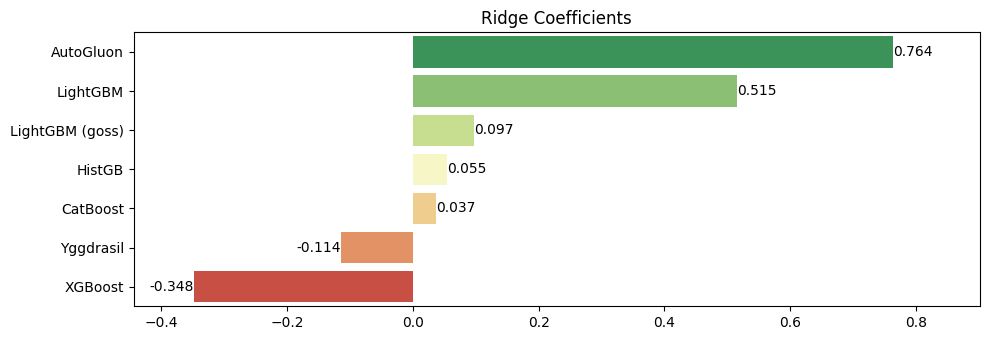

In [27]:
plot_weights(ridge_coeffs, "Ridge Coefficients")

# Submission

In [28]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = ridge_test_preds
sub.to_csv(f"sub_ridge_{np.mean(scores['Ridge (ensemble)']):.6f}.csv", index=False)
sub.head()

,id,Listening_Time_minutes
0,750000,54.712050
1,750001,18.498917
2,750002,49.757165
3,750003,77.086660
4,750004,48.465945


# Results

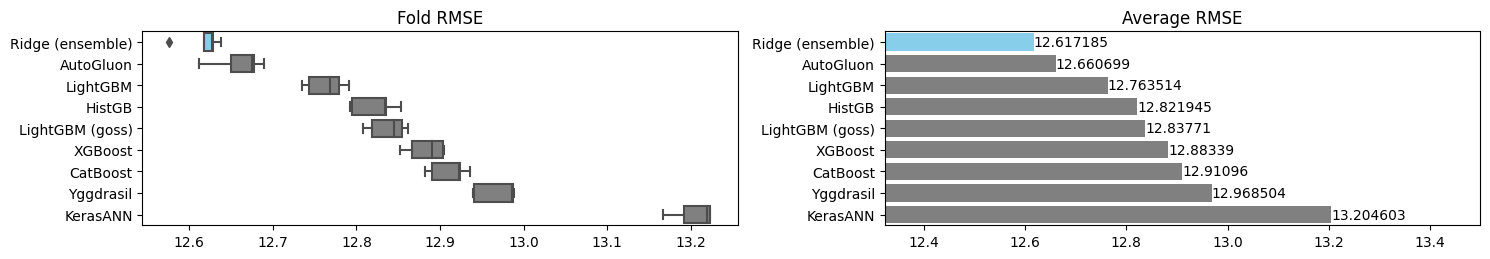

In [29]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold {CFG.metric}")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Average {CFG.metric}")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "skyblue" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

In [30]:
shutil.rmtree("catboost_info", ignore_errors=True)